<a href="https://colab.research.google.com/github/ranayash24/AutoEncoder-GAN/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import matplotlib.pyplot as plt


In [2]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root ='./data',train=True, download= True, transform= transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle= True)

100%|██████████| 9912422/9912422 [00:00<00:00, 68719956.70it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 110323947.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32858961.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4371392.56it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

In [4]:
dataiter = iter(data_loader)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [5]:
class Autoencoder(nn.Module):
  def __init__(self):
    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        nn.Linear(12,3),
        nn.ReLU()
    )
    self.dencoder = nn.Sequential(
        nn.Linear(3,12),
        nn.ReLU(),
        nn.Linear(12,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid()
    )

  def forward(self,x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded


In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [7]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [8]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0087
Epoch:2, Loss:0.0052
Epoch:3, Loss:0.0041
Epoch:4, Loss:0.0035
Epoch:5, Loss:0.0030
Epoch:6, Loss:0.0032
Epoch:7, Loss:0.0030
Epoch:8, Loss:0.0029
Epoch:9, Loss:0.0027
Epoch:10, Loss:0.0028


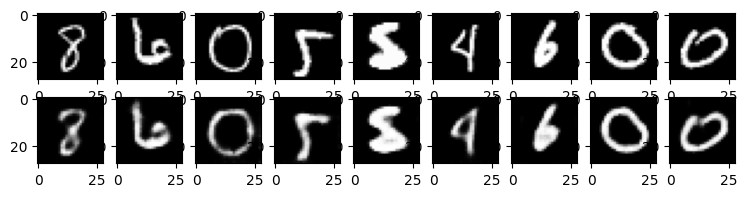

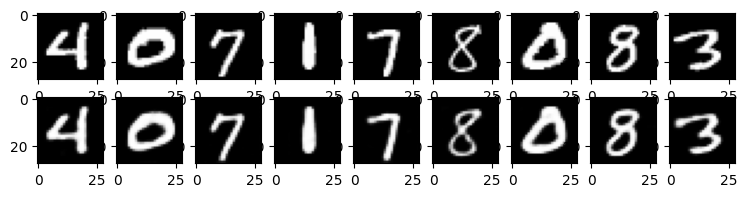

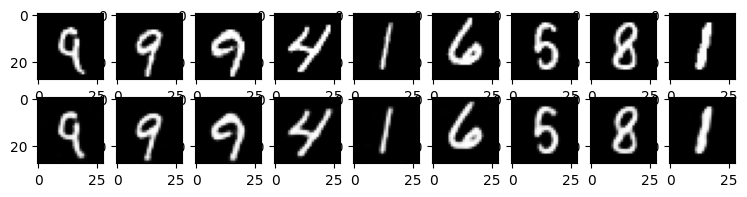

In [9]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])